In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [4]:
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data.csv', delimiter=',')

In [7]:
Dane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Columns: 151 entries, id to settlement_term
dtypes: float64(120), int64(1), object(30)
memory usage: 49.0+ MB


In [8]:
Dane.drop(39786, axis='index', inplace = True)
Dane.to_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', index = False)
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', delimiter=',')

In [9]:
Braki_danych = Dane.isna().sum()
i = 0
j = 0
while i < len(Dane.columns):
    if Braki_danych[j] > 1 / 2 * len(Dane):
        Dane.drop(Dane.columns[i], axis = 1, inplace = True)
    else:
        i = i + 1
    j += 1

In [10]:
Dane.drop(['emp_title', 'url', 'desc', 'title'], axis = 1, inplace = True)

In [11]:
Dane.drop(['issue_d', 'earliest_cr_line', 'delinq_2yrs', 'inq_last_6mths'], axis = 1, inplace = True)
Dane.drop(['total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee'], axis = 1, inplace = True)
Dane.drop(['recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis = 1, inplace = True)
Dane.drop(['last_fico_range_high', 'last_fico_range_low', 'acc_now_delinq', 'delinq_amnt', 'debt_settlement_flag'], axis = 1, inplace = True)

In [12]:
i = 0
while i < len(Dane.columns):
    if len(Dane.groupby(Dane.columns[i]).size()) == 1:
        Dane.drop(Dane.columns[i], axis = 1, inplace = True)
    else:
        i = i + 1

In [13]:
Dane.dropna(inplace = True)

In [14]:
Dane.to_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', index = False)

In [15]:
Dane = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_kopia.csv', delimiter=',')

In [16]:
for i in range(0, len(Dane)):
    if Dane.term[i] == ' 36 months':
        Dane.term[i] = 0
    else:
        Dane.term[i] = 1

C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/871762263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.term[i] = 0
C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/871762263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.term[i] = 1


In [17]:
for i in range(0, len(Dane)):
    Procent = Dane.int_rate[i]
    Procent_2 = Procent.strip(' ')
    Procent_3 = Procent_2.strip('%')
    Dane.int_rate[i] = float(Procent_3)

C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/3019499307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.int_rate[i] = float(Procent_3)


In [18]:
for i in range(0, len(Dane)):
    if Dane.emp_length[i] == '< 1 year':
        Dane.emp_length[i] = 0
    if Dane.emp_length[i] == '1 year':
        Dane.emp_length[i] = 1
    if Dane.emp_length[i] == '2 years':
        Dane.emp_length[i] = 2
    if Dane.emp_length[i] == '3 years':
        Dane.emp_length[i] = 3
    if Dane.emp_length[i] == '4 years':
        Dane.emp_length[i] = 4
    if Dane.emp_length[i] == '5 years':
        Dane.emp_length[i] = 5
    if Dane.emp_length[i] == '6 years':
        Dane.emp_length[i] = 6
    if Dane.emp_length[i] == '7 years':
        Dane.emp_length[i] = 7
    if Dane.emp_length[i] == '8 years':
        Dane.emp_length[i] = 8
    if Dane.emp_length[i] == '9 years':
        Dane.emp_length[i] = 9
    if Dane.emp_length[i] == '10+ years':
        Dane.emp_length[i] = 10

C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2203420458.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.emp_length[i] = 10
C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2203420458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.emp_length[i] = 0
C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2203420458.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.emp_length[i] = 1
C:\Users\mkraw\AppData\Local\

In [19]:
for i in range(0, len(Dane)):
    Procent = Dane.revol_util[i]
    Procent_2 = Procent.strip(' ')
    Procent_3 = Procent_2.strip('%')
    Dane.revol_util[i] = float(Procent_3)

C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/267926372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.revol_util[i] = float(Procent_3)


In [20]:
Dane.insert(14, 'loans_credit_policy', 0)
for i in range(0, len(Dane)):
    if Dane.loan_status[i] == 'Fully Paid' or Dane.loan_status[i] == 'Charged Off':
        Dane.loans_credit_policy[i] = 1
    if Dane.loan_status[i] == 'Does not meet the credit policy. Status:Fully Paid' or Dane.loan_status[i] == 'Does not meet the credit policy. Status:Charged Off':
        Dane.loans_credit_policy[i] = 0
    if Dane.loan_status[i] == 'Fully Paid' or Dane.loan_status[i] == 'Does not meet the credit policy. Status:Fully Paid':
        Dane.loan_status[i] = 1
    if Dane.loan_status[i] == 'Charged Off' or Dane.loan_status[i] == 'Does not meet the credit policy. Status:Charged Off':
        Dane.loan_status[i] = 0

C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2544988665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.loans_credit_policy[i] = 1
C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2544988665.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.loan_status[i] = 1
C:\Users\mkraw\AppData\Local\Temp/ipykernel_26540/2544988665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dane.loan_status[i] = 0
C:\Users\mkraw\AppD

In [21]:
Dane = pd.get_dummies(Dane, columns=['grade'])
Dane = pd.get_dummies(Dane, columns=['home_ownership'])
Dane = pd.get_dummies(Dane, columns=['verification_status'])

In [22]:
Dane[['id']] = Dane[['id']].astype(object)
Dane[['int_rate', 'revol_util', 'emp_length']] = Dane[['int_rate', 'revol_util', 'emp_length']].astype(float)
Dane[['term', 'loan_status']] = Dane[['term', 'loan_status']].astype(np.int64)

In [23]:
z = np.abs(stats.zscore(Dane[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
       'emp_length', 'annual_inc', 'dti', 'fico_range_low', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'pub_rec_bankruptcies', 'tax_liens']]))
Dane_outliers_removed = Dane[(z<3).all(axis=1)]
Dane_outliers_removed.to_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_bez_outliers.csv', index = False)
Dane_outliers_removed = pd.read_csv('C:/Users/mkraw/Downloads/Kurs/Projekt/Loan_data_bez_outliers.csv', delimiter=',')

In [24]:
x_fico = Dane[['fico_range_low']]
x_home = Dane[['home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT']]
x_income = Dane[['annual_inc']]
x_emp_length = Dane[['emp_length']]
x_loan_amnt = Dane[['loan_amnt']]
y = Dane[['loan_status']]

In [25]:
RegLog_fico = LogisticRegression()
RegLog_fico.fit(x_fico, y)
RegLog_fico.coef_

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[0.00250224]])

In [26]:
RegLog_home = LogisticRegression()
RegLog_home.fit(x_home, y)
RegLog_home.coef_

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[ 0.18600679, -0.35307038,  0.12124083,  0.04679345]])

In [27]:
RegLog_income = LogisticRegression()
RegLog_income.fit(x_income, y)
RegLog_income.coef_

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[2.48478671e-05]])

In [28]:
RegLog_emp_length = LogisticRegression()
RegLog_emp_length.fit(x_emp_length, y)
RegLog_emp_length.coef_

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[-0.01216756]])

In [29]:
RegLog_loan_amnt = LogisticRegression()
RegLog_loan_amnt.fit(x_loan_amnt, y)
RegLog_loan_amnt.coef_

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[-1.64277024e-05]])

In [31]:
X = Dane[['int_rate', 'revol_util', 'pub_rec', 'pub_rec_bankruptcies', 'loan_amnt', 'funded_amnt', 'dti', 'funded_amnt_inv', 'installment', 'emp_length', 'revol_bal', 'open_acc', 'annual_inc', 'fico_range_low', 'term', 'loans_credit_policy', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Verified', 'verification_status_Not Verified', 'verification_status_Source Verified', 'tax_liens']]
Y = Dane['loan_status']

In [ ]:
# Standaryzacja zmiennych

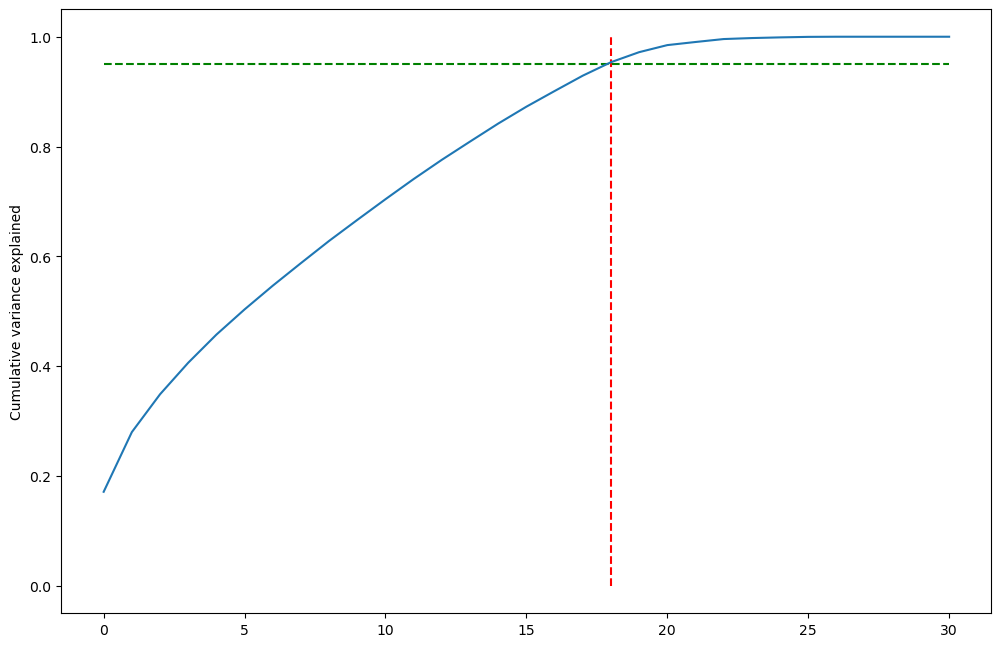

(40002, 18)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(random_state = 42)
pca.fit(X_scaled)
pca.components_[0]
pca.explained_variance_ratio_
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize = [12,8], dpi = 100)
plt.vlines(x=18, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()
pca_final = IncrementalPCA(n_components=18)
X_pca_final = pca_final.fit_transform(X_scaled)
X_pca_final.shape

In [83]:
k_m = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    k_m.append(kmeans.inertia_)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.1692168941951423
For n_clusters=3, the silhouette score is 0.11655774572093654
For n_clusters=4, the silhouette score is 0.133600044937032
For n_clusters=5, the silhouette score is 0.14266200196500645
For n_clusters=6, the silhouette score is 0.14775964536463837
For n_clusters=7, the silhouette score is 0.14488087068027117
For n_clusters=8, the silhouette score is 0.17117852880126944


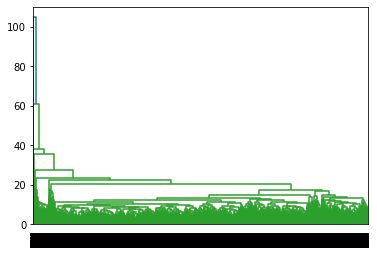

<Figure size 4000x4000 with 0 Axes>

In [89]:
cl_mergings = linkage(X_scaled, method="complete", metric='euclidean')
dendrogram(cl_mergings)
plt.show()

In [88]:
cl_cluster_labels = cut_tree(cl_mergings, n_clusters=2).reshape(-1, )
cl_cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
auroc = {}
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
RegLog = LogisticRegression()
RegLog.fit(x_train, y_train)
y_p_test = RegLog.predict(x_test)
auroc = pd.DataFrame({'Metoda':['Regresja logistyczna'], 'Score':[RegLog.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'0'})
dtree_t = DecisionTreeClassifier()
dtree_t.fit(x_train, y_train)
y_p_test = dtree_t.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Drzewo decyzyjne'], 'Score':[dtree_t.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test)]}, index={'1'})
auroc = pd.concat([auroc, tempResultsDf])
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
y_p_test = rf.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Las losowy'], 'Score':[rf.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'2'})
auroc = pd.concat([auroc, tempResultsDf])
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
y_p_test = gradient.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Gradient'], 'Score':[gradient.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'3'})
auroc = pd.concat([auroc, tempResultsDf])
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train, y_train)
y_p_test = ada_boost.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Ada boost'], 'Score':[ada_boost.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'4'})
auroc = pd.concat([auroc, tempResultsDf])
bagging = BaggingClassifier()
bagging.fit(x_train, y_train)
y_p_test = bagging.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['Bagging'], 'Score':[bagging.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'5'})
auroc = pd.concat([auroc, tempResultsDf])
kneighbors = KNeighborsClassifier()
kneighbors.fit(x_train, y_train)
y_p_test = kneighbors.predict(x_test)
tempResultsDf = pd.DataFrame({'Metoda':['K-neighbours'], 'Score':[kneighbors.score(x_test, y_test)], 'f1':[f1_score(y_test, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test)]}, index={'6'})
auroc = pd.concat([auroc, tempResultsDf])

C:\Users\mkraw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
auroc_2 = {}
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_final, Y, test_size = 0.2)
dtree_t = DecisionTreeClassifier()
dtree_t.fit(x_train_pca, y_train_pca)
y_p_test = dtree_t.predict(x_test_pca)
auroc_2 = pd.DataFrame({'Metoda':['Drzewo decyzyjne'], 'Score':[dtree_t.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC':[metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'1'})
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_pca, y_train_pca)
y_p_test = rf.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Las losowy'], 'Score':[rf.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'2'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
gradient = GradientBoostingClassifier()
gradient.fit(x_train_pca, y_train_pca)
y_p_test = gradient.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Gradient'], 'Score':[gradient.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'3'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
ada_boost = AdaBoostClassifier()
ada_boost.fit(x_train_pca, y_train_pca)
y_p_test = ada_boost.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Ada boost'], 'Score':[ada_boost.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'4'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
bagging = BaggingClassifier()
bagging.fit(x_train_pca, y_train_pca)
y_p_test = bagging.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['Bagging'], 'Score':[bagging.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'5'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])
kneighbors = KNeighborsClassifier()
kneighbors.fit(x_train_pca, y_train_pca)
y_p_test = kneighbors.predict(x_test_pca)
tempResultsDf = pd.DataFrame({'Metoda':['K-neighbours'], 'Score':[kneighbors.score(x_test_pca, y_test_pca)], 'f1':[f1_score(y_test_pca, y_p_test)], 'AUROC': [metrics.roc_auc_score(y_p_test, y_test_pca)]}, index={'6'})
auroc_2 = pd.concat([auroc_2, tempResultsDf])

In [76]:
auroc

,Metoda,Score,f1,AUROC
0,Regresja logistyczna,0.854768,0.921603,0.664680
1,Drzewo decyzyjne,0.751781,0.853302,0.522885
2,Las losowy,0.852768,0.920384,0.583472
3,Gradient,0.855643,0.922091,0.771740
4,Ada boost,0.855018,0.921685,0.686744
5,Bagging,0.828646,0.904480,0.574403
6,K-neighbours,0.833896,0.908941,0.506928


In [71]:
auroc_2

,Metoda,Score,f1,AUROC
1,Drzewo decyzyjne,0.756280,0.856195,0.527857
2,Las losowy,0.851019,0.919296,0.555073
3,Gradient,0.855393,0.922009,0.606705
4,Ada boost,0.854893,0.921718,0.566986
5,Bagging,0.823522,0.901644,0.549668
6,K-neighbours,0.834771,0.908916,0.554092


In [ ]:
# Powyższych tabeli wynika, że najlepszym modelem jest gradient (AUROC = 0.771740)
# utworzonym na podstawie zmiennych przed standaryzacją

In [96]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

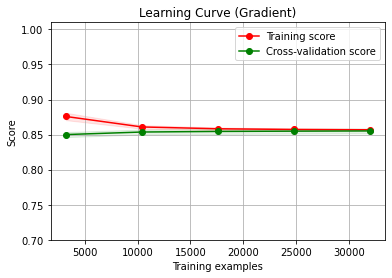

In [97]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
gradient = GradientBoostingClassifier()
plot_learning_curve(gradient, 'Learning Curve (Gradient)', X, Y, (0.7, 1.01), cv=cv, n_jobs=4)
plt.show()